Described in Saenz et al (2020) adapted to sentence embeddings


In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

# catpro
from utils.tokenizer import spacy_tokenizer
from utils.lemmatizer import spacy_lemmatizer
from utils import stop_words
from embeddings import vectorize
from embeddings import cosine_similarity


/Users/danielmlow/miniconda3/envs/catpro/lib/python3.7/site-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,


In [3]:
def df_similarity_token_category(embeddings_tokens_doc, constructs_d, df_train, docs_clean, summary_stats = None):
    feature_vectors_mean = []
    feature_vectors_median = []
    feature_vectors_max = []
    
    constructs = list(constructs_d.keys())

    for i, doc in enumerate(docs_clean):
        embeddings_tokens_doc_i = embeddings_tokens_doc[i]
        feature_vectors_category = []
        df_scores_category_all = []

        for category in constructs:
            embedding_category = constructs_d.get(category)
            cosine_scores = cosine_similarity(embedding_category, embeddings_tokens_doc_i)
            df_scores_category = pd.DataFrame([docs_clean[i], np.array(cosine_scores[0])]).T
            df_scores_category.columns = ['token', category]
            df_scores_category = df_scores_category.sort_values(by='token')
            # df_scores_category_all= df_scores_category_all.merge(df_scores_category, on='token', how = 'outer')
            df_scores_category_all.append(df_scores_category)
        df_scores_category_all = pd.concat(df_scores_category_all, axis=1)
        # df_scores_category_all = df_scores_category_all[constructs].astype(float)
        feature_vectors_mean.append(df_scores_category_all.mean())
        feature_vectors_median.append(df_scores_category_all.median())
        feature_vectors_max.append(df_scores_category_all.max())

    feature_vectors_mean = pd.concat(feature_vectors_mean,axis=1).T
    feature_vectors_mean.columns = [n+'_mean' for n in feature_vectors_mean.columns]

    feature_vectors_median = pd.concat(feature_vectors_median,axis=1).T
    feature_vectors_median.columns = [n+'_median' for n in feature_vectors_median.columns]
    
    feature_vectors_max = pd.concat(feature_vectors_max,axis=1).T
    feature_vectors_max.columns = [n+'_max' for n in feature_vectors_max.columns]
    
    feature_vectors = pd.concat([feature_vectors_mean, feature_vectors_median, feature_vectors_max],axis=1)
    feature_vectors[['subreddit', 'author', 'date','docs']] = df_train[['subreddit',  'author', 'date','post']].values
    feature_vectors['docs_clean']=docs_clean
    feature_cols = list(set(feature_vectors.columns)-set(['subreddit','author','date','docs','docs_clean']))
    feature_cols.sort()
    feature_vectors= feature_vectors[['subreddit','author','date','docs','docs_clean']+feature_cols]
    
    return feature_vectors

# Split into train and test set

In [4]:
run_this = False

if run_this:

    input_dir = './../../../reddit/input/'
    df = pd.read_csv(input_dir+'rmhd_27subreddits_1300posts.csv', index_col = 0)
    df

    # create a test set
    seed = 1234
    df_train = []
    df_test = []
    for category in df.subreddit.unique():
        df_cat = df[df['subreddit']==category]
        df_cat_train = df_cat.sample(frac=0.8, random_state=seed)
        other_indexes = [n for n in df_cat.index if n not in df_cat_train.index]
        df_cat_test = df_cat.loc[other_indexes]
        df_train.append(df_cat_train)
        df_test.append(df_cat_test)


    df_train = pd.concat(df_train).reset_index(drop = True)
    df_test = pd.concat(df_test).reset_index(drop = True)

    output_dir = './data/datasets/'
    os.makedirs(output_dir, exist_ok=True)
    df_train.to_csv(output_dir+'rmhd_27subreddits_1300posts_train.csv')
    df_test.to_csv(output_dir+'rmhd_27subreddits_1300posts_test.csv')
else:
    output_dir = './data/datasets/'
    df_train = pd.read_csv(output_dir+'rmhd_27subreddits_1300posts_train.csv', index_col = 0)
    df_test = pd.read_csv(output_dir+'rmhd_27subreddits_1300posts_test.csv', index_col = 0)
    
    
    
    
    
    

In [5]:
df_train

,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,EDAnonymous,lillylourose,2018/11/28,"The reason why I stoped with eating? Well, for...",0.478964,2.747789,2.109524,95.205000,86.583333,4.761905,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0
1,EDAnonymous,tinyTRONgirl,2019/10/15,I’m freaking out WHY can’t my body just digest...,5.559945,5.475852,6.247874,80.769913,67.394161,8.309854,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.131764,0.000000,0.00000,0.0
2,EDAnonymous,Vetmyana,2019/07/02,Tw weight loss achievement Just lost 8lbs (wei...,2.546452,4.004821,3.520194,91.910290,75.451613,4.960000,...,0.0,0.254812,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0
3,EDAnonymous,Fastingcametome,2019/07/25,When not eating is your solution to everything...,0.836122,2.859536,2.359891,95.598204,82.741497,5.824762,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.145753,0.00000,0.0
4,EDAnonymous,bananamo7,2019/04/19,How to dedicate a long weekend to beginning re...,5.119444,6.724697,6.719444,70.932500,69.185185,10.585185,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28075,unitedkingdom,Anomalous-Entity,2019/05/07,When someone is having a go at the U.S. and ma...,1.758324,4.527215,4.326374,77.275769,88.038462,6.048352,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.258879,0.000000,0.00000,0.0
28076,unitedkingdom,Squigglish,2019/03/28,My MP voted against every single Indicative Mo...,6.098205,9.032098,6.976923,52.759744,104.384615,7.887179,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0
28077,unitedkingdom,javaxcore,2019/09/02,What is Order 66? I have heard much talk of th...,0.761500,2.701924,1.290000,103.625000,82.500000,4.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0
28078,unitedkingdom,AlwaysGoForAusInRisk,2019/05/13,Seeing the GB Ambassador for Denmark today at ...,8.632452,8.773091,9.139258,61.853071,60.968504,12.296513,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0


# Choose subreddits to test method on

In [6]:
df_train.subreddit.unique()

array(['EDAnonymous', 'ForeverAlone', 'UKPersonalFinance', 'addiction',
       'adhd', 'alcoholism', 'anxiety', 'autism', 'bipolarreddit', 'bpd',
       'conspiracy', 'depression', 'divorce', 'guns', 'healthanxiety',
       'legaladvice', 'lonely', 'mentalhealth', 'mindfulness',
       'personalfinance', 'ptsd', 'schizophrenia', 'socialanxiety',
       'suicidewatch', 'teaching', 'ukpolitics', 'unitedkingdom'],
      dtype=object)

Word-based: 
- glove, bert, sense disambiguation bert

Phrase based:
- bert, sense disambiguation bert

1. clause detection
2. Use the pairwise comparison keybert but with phrases (not ngrams)

<AxesSubplot:ylabel='constructs'>

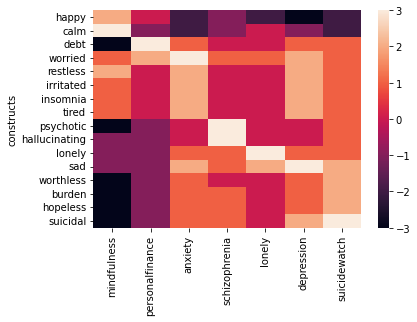

In [7]:
theoretical_similarities = pd.read_csv('data/concept_tracker_experiments/theoretical_similarities.csv', header=1,index_col=0)
sns.heatmap(theoretical_similarities)

In [8]:
subreddits = theoretical_similarities.columns.tolist()
constructs = theoretical_similarities.index.tolist()
print(subreddits, 
      constructs)

['mindfulness', 'personalfinance', 'anxiety', 'schizophrenia', 'lonely', 'depression', 'suicidewatch'] ['happy', 'calm', 'debt', 'worried', 'restless', 'irritated', 'insomnia', 'tired', 'psychotic', 'hallucinating', 'lonely', 'sad', 'worthless', 'burden', 'hopeless', 'suicidal']


In [9]:
df_train = df_train[df_train['subreddit'].isin(subreddits)]
# df_test = df_test[df_test['subreddit'].isin(subreddits)]

In [10]:
# docs = ["I am sad but hopeful.", "My grandmother who lives by Orlando is nice while she's drunk", "If I bought a gun, I plan on using it", "I am a boy and I am 18"]
docs = df_train.post.values
len(docs)

7280

In [11]:
# Minimal example
# model='en_core_web_sm'
# nlp = spacy.load(model)
# docs = nlp.pipe(['I feel consumed by pain'])
# for doc in docs:
#     for sent in doc.sents:
#         words = [(n.tag_, n.text, n.pos_) for n in sent]
#         break
#     break

# Tokenize into clauses

In [12]:
# docs_tokenized = spacy_tokenizer(docs, display_tree=False, remove_punct=True, 
#                                  clause_remove_conj = True)
# docs_tokenized

# Remove punctuation and stopwords

In [13]:
sws = stop_words.return_stopwords(language = 'en', method = 'nltk')
sws[:5]

['i', 'me', 'my', 'myself', 'we']

In [14]:
'just' in sws

True

In [15]:
more_sws = ['ca', 'nt','like', "'", "´", "n’t"]

In [17]:
%%time

run_this = False
if run_this:
    from utils import clean
    docs_clean = stop_words.remove(docs, language = 'en', method = 'nltk', remove_punct=True, extend_stopwords=more_sws)
    docs_clean = [n.replace('ampx200b', '').replace('\n','') for n in docs_clean]
    docs_clean = [clean.remove_multiple_spaces(doc) for doc in docs_clean]

    # docs_clean = spacy_lemmatizer(docs_clean, language ='en') #this takes 22s for 5200 docs


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


# Encode into word embeddings and compute similarity between tokens and category embeddings

In [18]:
%%time
# docs_clean = spacy_lemmatizer(docs_clean, language ='en') #this takes 22s for 5200 docs

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.2 µs


In [19]:

embedding_name_type = {
#    model_name:embedding_type 
    'glove': 'word',
    'all-MiniLM-L6-v2': 'sentence',
    # 'all-MiniLM-L6-v2': 'document',
    'mnaylor/psychbert-cased': 'document',# need to fix
    
    
    
    
}

In [20]:
output_dir = './data/concept_tracker_experiments/direct_similarity/'

In [21]:
# filename = model_name.split('/')[-1]
# filename

In [22]:
# docs_clean2 = docs_clean[:10]
# df_train2 = df_train.iloc[:10,:]

# may need to do on Colab with GPU or cluster

In [37]:
# docs_toy = docs_clean[:6]
docs = list(docs[:6])
docs

["How many people here work and had a hard time being around new people? I know my anxiety has made it hard for me to get a job in the past. When i talk to strangers it's one they I'll probably not seem them again, but with coworkers you see them every day. \n\nHow do you introduce yourself and what do you all say when first meeting them. Also when and if someone asked what you do for fun or what your hobbies were what did you say. Because again i know anxiety can make it hard for people to go out and do things. And i feel like saying  watching tv, reading, fishing are all kinda boring and introverted answers. \n\nI wanna be able to go out maybe make friends with the new coworkers but idk how to come off as a fun person and that i'm open to going to the bar or something after work or hanging out. \n\nI'm not a interesting person and as shitty as it sounds i kinda just wanna do my job and leave but i know i have to be social, i can't just be someone who ignores everyone.",
 "How to deal

In [43]:
%%timeit
embeddings1 = vectorize(docs, package = 'sentence_transformers', model_name = 'all-MiniLM-L6-v2', embedding_type = 'sentence')

docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
4.67 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
print(embeddings1.shape)


(6, 384)


In [44]:
%%timeit
embeddings4 = vectorize(docs, package = 'flair', model_name = 'all-MiniLM-L6-v2', embedding_type = 'sentence')


docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
docs x embedding size: (6, 384)
4.64 s ± 726 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
from flair.embeddings import SentenceTransformerDocumentEmbeddings

In [50]:
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

In [33]:

%%time
embeddings6 = vectorize(docs, package = 'flair', model_name = 'sentence-transformers/all-MiniLM-L6-v2', embedding_type = 'document')

docs x embedding size: (6, 384)
CPU times: user 1.83 s, sys: 68.6 ms, total: 1.9 s
Wall time: 3.18 s


In [47]:

%%time
embeddings7 = vectorize(docs, package = 'transformers', model_name = 'sentence-transformers/all-MiniLM-L6-v2', embedding_type = 'sentence')

CPU times: user 8.29 s, sys: 582 ms, total: 8.87 s
Wall time: 9.88 s


In [35]:
embeddings1 == embeddings4

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

In [45]:
embeddings1 == embeddings6

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [40]:
embeddings1 

array([[-0.02277171, -0.10805278,  0.01971223, ...,  0.08205864,
        -0.06165227,  0.04337246],
       [ 0.08137938, -0.02030696, -0.05132398, ...,  0.05769289,
        -0.06577477, -0.00207761],
       [ 0.05749402, -0.02804438,  0.04105259, ..., -0.00172726,
        -0.09628459,  0.03997312],
       [ 0.00951926, -0.08110527,  0.09098199, ...,  0.00262262,
        -0.06013191,  0.03284144],
       [ 0.05367722, -0.11676581, -0.0309427 , ...,  0.03174809,
        -0.16367418,  0.01410951],
       [-0.00254147, -0.0350326 ,  0.01911239, ..., -0.02602109,
         0.05524712,  0.02816032]], dtype=float32)

In [42]:
embeddings4

array([[-0.02277170866727829, -0.10805278271436691, 0.01971222646534443,
        ..., 0.08205863833427429, -0.06165227293968201,
        0.04337245598435402],
       [0.08137937635183334, -0.02030695602297783, -0.05132397636771202,
        ..., 0.057692889124155045, -0.06577476859092712,
        -0.0020776099991053343],
       [0.05749399960041046, -0.02804434299468994, 0.041052594780921936,
        ..., -0.0017272422555834055, -0.09628456085920334,
        0.039973143488168716],
       [0.009519238956272602, -0.08110525459051132, 0.09098196774721146,
        ..., 0.002622605999931693, -0.06013190746307373,
        0.03284144029021263],
       [0.05367721989750862, -0.1167658120393753, -0.030942704528570175,
        ..., 0.03174808621406555, -0.16367417573928833,
        0.014109505340456963],
       [-0.002541513880714774, -0.03503258153796196, 0.01911240629851818,
        ..., -0.026021117344498634, 0.05524717643857002,
        0.028160328045487404]], dtype=object)

In [41]:
embeddings7

tensor([[ 0.0328, -0.0419, -0.0062,  ...,  0.0142,  0.0204, -0.0056],
        [ 0.0039, -0.0382,  0.0128,  ...,  0.0538,  0.0224,  0.0279],
        [-0.0159,  0.0213,  0.0063,  ...,  0.0266,  0.0164,  0.0573],
        [ 0.0280, -0.0215,  0.0086,  ..., -0.0357,  0.0489, -0.0489],
        [-0.0519,  0.0739, -0.0224,  ...,  0.0046, -0.0064, -0.0191],
        [-0.0099,  0.0270, -0.0043,  ...,  0.0040,  0.0431, -0.0182]])

In [46]:
%%timeit
embeddings5 = vectorize(docs, package = 'flair', model_name = 'distilroberta-base', embedding_type = 'document')

docs x embedding size: (6, 768)
docs x embedding size: (6, 768)
docs x embedding size: (6, 768)
docs x embedding size: (6, 768)
docs x embedding size: (6, 768)
docs x embedding size: (6, 768)
docs x embedding size: (6, 768)
docs x embedding size: (6, 768)
6.64 s ± 287 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%time
embeddings2 = vectorize(docs, package = 'flair', model_name = 'glove', embedding_type = 'word')
embeddings3 = vectorize(docs, package = 'flair', model_name = 'distilbert-base-uncased', embedding_type = 'transformer_word')
embeddings5 = vectorize(docs, package = 'flair', model_name = 'distilroberta-base', embedding_type = 'document')


In [87]:
embedding_name_type.items()

dict_items([('glove', 'word'), ('all-MiniLM-L6-v2', 'sentence'), ('mnaylor/psychbert-cased', 'document')])

In [88]:
for model_name, embedding_type in embedding_name_type.items():


    if model_name in ['glove','mnaylor/psychbert-cased']:
        # skip             
        continue
    print(model_name, embedding_type)

all-MiniLM-L6-v2 sentence


In [100]:
constructs

['happy',
 'calm',
 'debt',
 'worried',
 'restless',
 'irritated',
 'insomnia',
 'tired',
 'psychotic',
 'hallucinating',
 'lonely',
 'sad',
 'worthless',
 'burden',
 'hopeless',
 'suicidal']

In [99]:
df_similarity_token_category(embeddings_tokens_doc, constructs_d, df_train, docs_clean, summary_stats = None)


ValueError: setting an array element with a sequence.

In [109]:
embeddings_tokens_doc[2].shape

(46, 100)

In [96]:
%%time

run_this = True

if run_this:
    for model_name, embedding_type in embedding_name_type.items():
        if model_name in ['all-MiniLM-L6-v2','mnaylor/psychbert-cased']:
            # skip             
            continue
        print(model_name, embedding_type)
        # encode tokens of each doc
        embeddings_tokens_doc = vectorize(docs_clean, embedding_type = embedding_type, model_name = model_name) # 10 s for list of tokens for 5200 docs
        filename = model_name.split('/')[-1]
        np.save(output_dir+f'rmhd_5_{filename}_embeddings.npy', embeddings_tokens_doc)

        # encode constructs     
        constructs_d = {}
        embeddings_constructs = vectorize(constructs, embedding_type = embedding_type, model_name = model_name)
        for category, embedding in zip(constructs, embeddings_constructs):
            constructs_d[category] = embedding

        # compute similarity (extract features)    
        # embeddings_tokens_doc = np.load(output_dir+f'rmhd_5_{model_name.split('/')[-1]}_embeddings.npy')
        feature_vectors = df_similarity_token_category(embeddings_tokens_doc, constructs_d, df_train, docs_clean, summary_stats = None)
        feature_vectors.to_csv(output_dir+f'feature_vectors_{filename}_{len(constructs)}constructs_{len(subreddts)}subreddits.csv')


glove word


/Users/danielmlow/Dropbox (MIT)/datum/catpro/catpro/text/embeddings.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embeddings = np.asarray(embeddings)


size of embeddings: (7280,)
size of embeddings: (16, 1, 100)


ValueError: setting an array element with a sequence.


# Plot

In [80]:
feature_vectors[['docs', 'docs_clean']].values

NameError: name 'feature_vectors' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# feature_vectors.groupby('subreddit')[cols].boxplot()

In [ ]:
output_dir = './data/concept_tracker_experiments/direct_similarity/'

In [ ]:
feature_vectors = pd.read_csv(output_dir+f'feature_vectors_{filename}.csv', index_col = 0)

In [ ]:
for category in constructs:
    print('\n\n',category, '========= >0.6')
    fv_i = feature_vectors[feature_vectors[category+'_mean']>0.5]
    if fv_i.shape[0]>1:
        
        display(
            fv_i[['docs', category+'_mean','subreddit']].round(3).sample(n=3).values.tolist()
        )

    print('\n\n',category, '========= 0.4>=x<=0.6')
    fv_i = feature_vectors[(feature_vectors[category+'_mean']>0.4) & (feature_vectors[category+'_mean']<=0.6) ]
    if fv_i.shape[0]>1:
        
        display(
            fv_i[['docs', category+'_mean', 'subreddit']].round(3).sample(n=3).values.tolist()
        )
    
    
#     print('\n',category, '========= 0.3>=x<=0.5')
#     display(
#         feature_vectors[feature_vectors[category+'_mean']>0.5]['docs'].sample(n=3).tolist()
#     )

In [ ]:
from matplotlib import rcParams

sns.set(font_scale=1.4)

# figure size in inches
# rcParams['figure.figsize'] = 8,6

for model_name, embedding_type in embedding_name_type.items():
    
    if model_name in ['mnaylor/psychbert-cased']:
        continue
    
    filename = model_name.split('/')[-1]
    feature_vectors = pd.read_csv(output_dir+f'feature_vectors_{filename}.csv', index_col = 0)
    
    
    
    print(model_name)
    print('==============================')
    for stat in ['mean', 'median', 'max']:
        print(stat, '---')
        cols = [n for n in feature_vectors.columns if stat in n]
        display(feature_vectors.groupby('subreddit').mean()[cols])
        
        # sns.set(rc = {'figure.figsize':(4,4)})
        # plt.rcParams["figure.figsize"] = (4,4)
        # plt.figure(figsize=(4,4))

        # import matplotlib.pyplot as plt


        sns.clustermap(
                feature_vectors.groupby('subreddit').mean()[cols]
            )
        plt.title(f'{model_name} - {stat}', size=20)
        plt.show()
        
        feature_vectors_normalized = feature_vectors[[n for n in feature_vectors.columns if stat in n]]
        feature_vectors_normalized=(feature_vectors_normalized-feature_vectors_normalized.mean())/feature_vectors_normalized.std()
        feature_vectors_normalized['subreddit']=feature_vectors['subreddit'].values
        display(feature_vectors_normalized.groupby('subreddit').mean()[cols])

        # plt.figure(figsize=(8,8))
        sns.clustermap(feature_vectors_normalized.groupby('subreddit').mean())
        plt.title(f'{model_name} - {stat} standardized', size=20)

        plt.show()
        
        
        
